In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

In [4]:
# get the data for the stock

# Get today's date
today = datetime.now()

# Get the date from 2 years ago
two_years_ago = today - timedelta(days=2*364) # TODO - change back to 2 years

# Format the dates as requested
end_date = today.strftime("%Y-%m-%d")
start_date = two_years_ago.strftime("%Y-%m-%d")


# Fetch the historical SPY data from Yahoo Finance
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1h')

# Reformat the data to fit the sma_crossover_backtester() function
spy_data = spy_data.reset_index()
spy_data['timestamp'] = spy_data['Datetime']
spy_data['price'] = spy_data['Open']



[*********************100%***********************]  1 of 1 completed


In [5]:
# add quarters to the data

# Make sure the 'Datetime' column is in datetime format
spy_data['Datetime'] = pd.to_datetime(spy_data['Datetime'])

# Calculate the start date and year of the first entry
start_date = spy_data['Datetime'].min()
start_year = start_date.year

# Create a function to calculate the quarter
def calculate_quarter(row):
    months_passed = (row['Datetime'].year - start_year) * 12 + row['Datetime'].month - start_date.month
    return (months_passed // 3) + 1

# Apply the function to create the 'quarter' column
spy_data['quarter'] = spy_data.apply(calculate_quarter, axis=1)

spy_data

,Datetime,Open,High,Low,Close,Adj Close,Volume,timestamp,price,quarter
0,2021-08-23 09:30:00-04:00,445.160004,447.200012,445.140015,446.869995,446.869995,12617344,2021-08-23 09:30:00-04:00,445.160004,1
1,2021-08-23 10:30:00-04:00,446.869995,447.739990,446.709991,447.480011,447.480011,7666372,2021-08-23 10:30:00-04:00,446.869995,1
2,2021-08-23 11:30:00-04:00,447.484985,447.940002,447.484985,447.839996,447.839996,5672760,2021-08-23 11:30:00-04:00,447.484985,1
3,2021-08-23 12:30:00-04:00,447.850006,448.230011,447.579987,447.695007,447.695007,5822830,2021-08-23 12:30:00-04:00,447.850006,1
4,2021-08-23 13:30:00-04:00,447.709991,447.989990,447.429993,447.750000,447.750000,5155800,2021-08-23 13:30:00-04:00,447.709991,1
...,...,...,...,...,...,...,...,...,...,...
3490,2023-08-18 11:30:00-04:00,435.260010,436.551086,434.709991,435.704987,435.704987,8679631,2023-08-18 11:30:00-04:00,435.260010,9
3491,2023-08-18 12:30:00-04:00,435.734985,436.529999,434.750000,435.549988,435.549988,8346110,2023-08-18 12:30:00-04:00,435.734985,9
3492,2023-08-18 13:30:00-04:00,435.549988,436.290009,435.160004,435.954987,435.954987,9039348,2023-08-18 13:30:00-04:00,435.549988,9
3493,2023-08-18 14:30:00-04:00,435.940002,436.760010,435.359985,436.140015,436.140015,10345467,2023-08-18 14:30:00-04:00,435.940002,9


In [6]:
def sma_crossover_backtester(sampled_data, 
                            order_sizing, 
                            ma1_length, 
                            ma2_length, 
                            starting_capital,
                            display_results,
                            shorting_allowed,
                            fixed_fee,
                            record_balance,
                            show_moving_averages,
                            annual_taxes,
                            tax_percentage = 0,
                            fee=0
                            ):
    """ 
    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma1_length: moving average 1 length (in hours)
        ma2_length: moving average 2 length (in hours, must be longer than ma1_length)
        starting_capital: how much capital to start with (USD)
        display_results: plot the portfolio value over time (true or false)
        shorting_allowed: whether or not to short or sell regularly (true or false)
        fixed_fee: whether to use volume based fee or a fixed fee (true or false)
        fee: if fixed fee, the % charged per transaction by the exchange (0.01 = 1%), default = 0
        record_balance: whether or not to track the balance over the whole period
        show_moving_averages: whether or not to show the moving averages in the plot displayed (true or false)
        annual_taxes: whether or not to take annual taxes on gains (true or false)
        tax_percentage: if taxes are enabled, what % of taxes to pay on gains (0.01 = 1%), default = 0
    Returns:
        backtest_results: dictionary that contains backtest result metrics and balance information 
    """

    # for figuring out how much a fee is
    # we are taking the average of maker and taker fees on coinbase pro starting on 6/5/23
    def find_fee(thirty_day_volume):
        volume_fee_table = {
            10000: 0.005,
            50000: 0.00325,
            100000: 0.002,
            1000000: 0.0015,
            15000000: 0.0013,
            75000000: 0.0011,
            250000000: 0.00075,
            400000000: 0.0004,
        }
        
        for volume, fee in volume_fee_table.items():
            if thirty_day_volume <= volume:
                return fee
        
        # If the volume is greater than the largest key, return the fee for the largest key
        return volume_fee_table[400000000]

    
    import math 
    import statistics 
    import numpy as np
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if ma2_length < ma1_length:
        return "Could not run ma_crossover_backtester(), ma1_length is larger than ma2_length."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    # setup for keeping track of quarterly results
    three_month_hours = 2191
    one_month_hours = 730 #actually 730.5 
    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []

    monthly_return_rates = []

    # calculate the total number of quarters in the dataset
    # calculate the total number of quarters in the dataset
    total_quarters = max(list(sampled_data['quarter']))
    # total_quarters = math.floor(len(sampled_data.index)/three_month_hours)
    # total_months = math.floor(len(sampled_data.index)/one_month_hours)

    # # calculate quarter intervals
    # quarter_intervals = [three_month_hours*x for x in range(0, total_quarters)]
    # monthly_intervals = [one_month_hours*x for x in range(0, total_months)]

    # # convert to get the corresponding timestamps
    # quarter_intervals = [sampled_data.iloc[x]['timestamp'] for x in quarter_intervals]
    # monthly_intervals = [sampled_data.iloc[x]['timestamp'] for x in monthly_intervals]
    
    current_price = sampled_data['price'][0]
    baseline_position_size = starting_capital/current_price
    baseline_initial = current_price

    ma1 = sampled_data.price.rolling(ma1_length).mean()
    ma2 = sampled_data.price.rolling(ma2_length).mean()

    #truncate the data so they all are aligned 
    ma1 = list(ma1[ma2_length:])
    ma2 = list(ma2[ma2_length:])
    sampled_data = sampled_data[ma2_length:]
    last_average_higher = "None"

    # set up shorting mechanism
    short_position = None
    short_results = []

    # set up volume data
    thirty_day_volume = 0
    volume_data = []

    # set up tax information, when the year changes, we check if we gained or lost for the year, and then put that aside for taxes
    sampled_data['timestamp'] = pd.to_datetime(sampled_data['timestamp'])

    past_year = sampled_data.iloc[0]['timestamp'].year
    annual_change = 0
    past_quarter = 1
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        # calculate the fee using the thirty_day_volume
        if not fixed_fee:
            fee = find_fee(thirty_day_volume)

        #get the current price
        current_price = sampled_data.iloc[x]['price']
        current_quarter = sampled_data.iloc[x]['quarter']

        if x == 0:
            #baseline_initial = current_price
            #baseline_position_size = starting_capital/current_price
            quarter_initial = current_price

            monthly_initial_balance = starting_capital
            quarter_initial_balance = starting_capital
            quarter_baseline_initial_balance = starting_capital

            annual_baseline_balance = starting_capital

        # if the year has changed, calculate how much has happened
        if annual_taxes == True:
            current_year = sampled_data.iloc[x]['timestamp'].year
            if current_year != past_year:
                # the year has changed
                if short_position == True:
                    short_delta = (purchase_price*position_size - current_price*position_size)
                    current_balance = (purchase_price*position_size + short_delta + fiat)
                else:
                    current_balance = current_price*position_size + fiat

                annual_change = current_balance - annual_baseline_balance

                # if we had a gain that year, you need to pay taxes
                if annual_change > 0:
                    taxes_due = annual_change*tax_percentage
                    
                    # if currently holding a position, will need to sell some of it to make up for the taxes...(since fiat is probably low)
                    if position_size != 0:
                        taxes_due = annual_change*tax_percentage - fiat #use all fiat first
                        amount_to_sell = taxes_due/current_price # find out how many shares will cover the amount due
                        position_size = position_size - amount_to_sell # reduce that many shares from the amount due
                    else:
                        fiat = fiat - taxes_due
                
                # reset the new amount
                annual_baseline_balance = position_size*current_price + fiat
            
            past_year = current_year
        
        # if a new month begins, calculate the return for that month (for sharpe ratio calculations)
        # if sampled_data.iloc[x]['timestamp'] in monthly_intervals:
        #     monthly_return_rate = ((fiat + current_price*position_size)/monthly_initial_balance) - 1
        #     monthly_return_rates.append(monthly_return_rate)
        #     monthly_initial_balance = fiat + current_price*position_size

        # If a new quarter begins, calculate metrics for the quarter
        if current_quarter != past_quarter:
            quarter_return_rate = ((fiat + current_price*position_size)/quarter_initial_balance) - 1
            quarter_return_rates.append(quarter_return_rate)
            quarter_trades.append(trades)
            baseline_return_rate = ((baseline_position_size*current_price)/quarter_baseline_initial_balance) - 1
            baseline_return_rates.append(baseline_return_rate)

            if (losses + wins) > 0:
                hit_rate = wins/(losses + wins)
            else:
                hit_rate = "N/A"

            quarter_hit_rates.append(hit_rate)

            # reset initial price for the quarter
            quarter_initial = current_price

            # reset number of trades, losses, wins
            trades = 0
            losses = 0
            wins = 0

            # calculate the new initial portfolio worth to be used for the new quarter
            quarter_initial_balance = fiat + current_price*position_size
            quarter_baseline_initial_balance = current_price*baseline_position_size
        
        past_quarter = current_quarter
            
        #keep track of which one was higher previously
        if ma1[x] > ma2[x]:
            current_average_higher = "MA1"
        elif ma1[x] < ma2[x]:
            current_average_higher = "MA2"
        else:
            current_average_higher = "None"

        if x == 0:
            pass
            #moves.append("Pass")
        else:
            #begin the trading mechanism

            #if the shorter average crosses over the longer average - BUY
            if current_average_higher == "MA1" and last_average_higher == "MA2":
                if shorting_allowed == True:
                    if short_position == True:
                        # if there is a short position, exit out of it
                        short_delta = (purchase_price*position_size - current_price*position_size) # calculate the delta for the short
                        short_results.append(short_delta)
                        fiat = fiat + (purchase_price*position_size + short_delta)*(1 - fee) # sell the position and the short
                        position_size = 0 # set the position to zero
                    
                    short_position = False


                #add the btc amount to the position
                position_size = position_size + (order_sizing*fiat*(1 - fee))/current_price #add the btc purchased
                
                # record the volume information (the amount purchased)
                volume_data.append([
                    0,(order_sizing*fiat*(1 - fee))/current_price
                ])

                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                #moves.append("Buy")
                trades = trades + 1
                purchase_price = current_price

                

            #if the shorter average goes under the longer average - SELL
            elif current_average_higher == "MA2" and last_average_higher == "MA1":
                fiat = fiat + position_size*current_price*(1 - fee)
                position_size = 0

                # record the volume information (the amount sold)
                volume_data.append([
                    0,position_size*current_price*(1 - fee)
                ])

                if shorting_allowed == True:
                    position_size = (order_sizing*fiat*(1 - fee))/current_price
                    fiat = fiat - position_size*current_price
                    short_position = True
                    purchase_price = current_price
                    #moves.append("Short-Sell")
                else:
                    pass
                    purchase_price = 0
                    #moves.append("Sell")

                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1
                

            else:
                pass
                #moves.append("Pass")

        if shorting_allowed == True:
            #record the portfolio information
            if short_position == False or short_position == None:
                if record_balance == True:
                    portfolio_balance.append(position_size*current_price + fiat)
            if short_position == True:
                short_delta = (purchase_price*position_size - current_price*position_size)
                if record_balance == True:
                    portfolio_balance.append(purchase_price*position_size + short_delta + fiat)
        else:
            #record the portfolio information
            if record_balance == True:
                portfolio_balance.append(position_size*current_price + fiat)
            
        if record_balance == True:
            baseline_balance.append(baseline_position_size*current_price)
        
        #record which moving average was higher this moment
        last_average_higher = current_average_higher

        # go through the volume data
        thirty_day_volume = 0 # re-calculate the current thirty_day_volume
        new_volume_data = []
        for volume_data_entry in volume_data:
            if volume_data_entry[0] < 720: # 720 hours in thirty days
                thirty_day_volume = thirty_day_volume + volume_data_entry[1]
                new_volume_data.append([volume_data_entry[0] + 1, volume_data_entry[1]])
        
        volume_data = new_volume_data

    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1    
    final_return_rate = ((position_size*current_price + fiat)/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # calculate sharpe ratio (using 0% as the risk-free return benchmark)
    #sharpe_ratio = (statistics.mean(monthly_return_rates)-0)/(statistics.stdev(monthly_return_rates)*np.sqrt(12))
    sharpe_ratio = None

    if display_results == True and record_balance == True:
        plot_data = pd.DataFrame()
        plot_data['time'] = sampled_data['timestamp']
        plot_data['Baseline'] = baseline_balance
        plot_data['SMA Crossover'] = portfolio_balance
        if show_moving_averages:
            plot_data["MA1"] = [i*baseline_position_size for i in ma1]
            plot_data["MA2"] = [i*baseline_position_size for i in ma2]
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()
    else:
        plot_data = "Could not generate plot_data: display_results and/or record_balance was set to False."

    # calculate quarters_beating_baseline
    count = 0
    for x in range(0, len(quarter_return_rates)):
        if quarter_return_rates[x] > baseline_return_rates[x]:
            count = count + 1
    
    quarters_beating_baseline = round(count/len(quarter_return_rates), 2)

    # return the results
    backtest_results = {"final_return_rate" : final_return_rate,
               "hit_rate": hit_rate,
               "baseline_return_rate": baseline_return_rate,
               "quarter_return_rates": quarter_return_rates, 
               "quarter_trades": quarter_trades,
               "quarter_hit_rates": quarter_hit_rates,
               "baseline_return_rates": baseline_return_rates,
               "balance_data": plot_data,
               "sharpe_ratio": sharpe_ratio,
               "quarters_beating_baseline": quarters_beating_baseline,
               "strategy_quarterly_stdev": statistics.stdev(quarter_return_rates),
               "baseline_quarterly_stdev": statistics.stdev(baseline_return_rates)

    }
    
    return backtest_results

def plot_quarterly_data(backtest_results):
    '''
    Visualize quarterly data from a backtest run.

    Parameters:
        backtest_results: dict generated by sma_crossover_backtester()
    Returns:
        None
    '''

    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    quarterly_data = pd.DataFrame()
    quarterly_data['quarter'] = [x + 1 for x in range(0, len(backtest_results["quarter_return_rates"]))]
    quarterly_data['return'] = [x*100 for x in backtest_results["quarter_return_rates"]]
    quarterly_data['trades'] = backtest_results["quarter_trades"]
    quarterly_data['hit_rate'] = backtest_results["quarter_hit_rates"]
    quarterly_data['baseline'] = [x*100 for x in backtest_results["baseline_return_rates"]]

    # Hit Rate
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="hit_rate",data=quarterly_data,palette=clrs)
    #Drawing a horizontal line at 0.5
    graph.axhline(0.5)
    plt.show()

    # Returns
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="return",data=quarterly_data,palette=clrs)
    plt.show()

    # Number of trades
    graph = sns.barplot(x="quarter",y="trades",data=quarterly_data,palette=clrs)
    plt.show()

    # Comparing quarterly returns
    comparison_df = pd.DataFrame()
    comparison_df['Return (%)']  = list(quarterly_data['return']) + list(quarterly_data['baseline'])
    comparison_df['Quarter'] = [x for x in quarterly_data['quarter']] + [x for x in quarterly_data['quarter']]
    comparison_df['Strategy'] = ["SMA Crossover" for x in quarterly_data['quarter']] + ["Buy and Hold" for x in quarterly_data['quarter']]

    sns.barplot(data=comparison_df, x='Quarter', y='Return (%)', hue='Strategy')
    plt.show()

/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


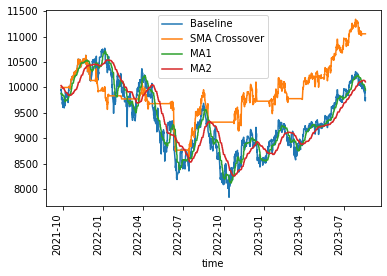

{'final_return_rate': 0.10549890470618029,
 'hit_rate': 1.0,
 'baseline_return_rate': -0.020262352725916366,
 'quarter_return_rates': [0.03383378049538832,
  -0.048665091438742314,
  -0.015589204080523444,
  -0.02374242570527274,
  0.01699010212332208,
  0.03115531877369615,
  0.037961551977274466,
  0.09558610685574775],
 'quarter_trades': [1, 5, 4, 3, 2, 2, 2, 2],
 'quarter_hit_rates': ['N/A', 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'baseline_return_rates': [0.033740652552138206,
  -0.020644096117175548,
  -0.08416169630824522,
  -0.007874015748031482,
  -0.04727713150564705,
  0.0388321969745562,
  0.025117798270748448,
  0.09800948588601499],
 'balance_data':                           time     Baseline  SMA Crossover          MA1  \
 168  2021-09-27 09:30:00-04:00  9951.478038   10000.000000  9883.165043   
 169  2021-09-27 10:30:00-04:00  9970.104894   10000.000000  9882.649872   
 170  2021-09-27 11:30:00-04:00  9952.938242   10000.000000  9881.430736   
 171  2021-09-27 12:30:00-04

In [7]:
# Run the crossover backtester without shorting
backtest_results = sma_crossover_backtester(
            sampled_data = spy_data,
            order_sizing = 1,
            ma1_length = 48, 
            ma2_length = 168, 
            starting_capital = 10000,
            display_results=True,
            shorting_allowed=False,
            fixed_fee = True,
            record_balance = True,
            show_moving_averages = True,
            annual_taxes=True,
            tax_percentage=0.3,
            fee = 0
        )

backtest_results


/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


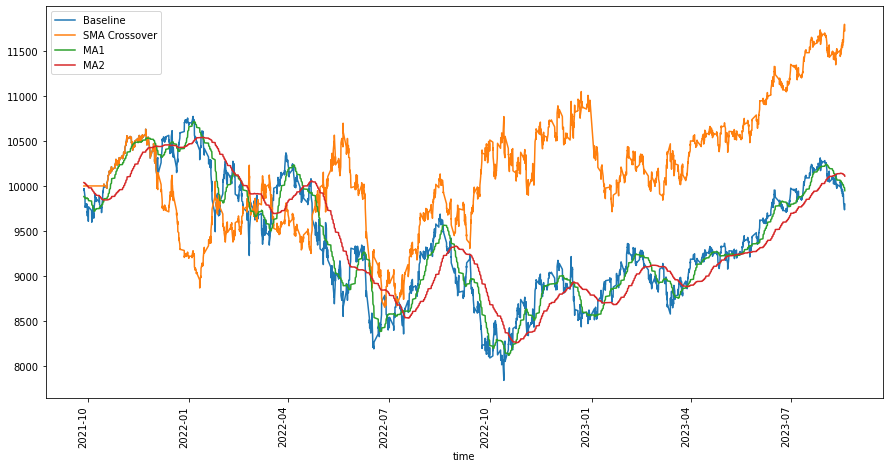

{'final_return_rate': 0.11486183632392843,
 'hit_rate': 0.0,
 'baseline_return_rate': -0.020262352725916366,
 'quarter_return_rates': [0.03383378049538832,
  -0.15637073269634905,
  0.005837088738738894,
  0.09685821545253637,
  0.08125733575229144,
  -0.024282162820153497,
  0.050805305683800484,
  0.09316272782548096],
 'quarter_trades': [1, 5, 4, 3, 2, 2, 2, 2],
 'quarter_hit_rates': ['N/A', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'baseline_return_rates': [0.033740652552138206,
  -0.020644096117175548,
  -0.08416169630824522,
  -0.007874015748031482,
  -0.04727713150564705,
  0.0388321969745562,
  0.025117798270748448,
  0.09800948588601499],
 'balance_data':                           time     Baseline  SMA Crossover          MA1  \
 168  2021-09-27 09:30:00-04:00  9951.478038   10000.000000  9883.165043   
 169  2021-09-27 10:30:00-04:00  9970.104894   10000.000000  9882.649872   
 170  2021-09-27 11:30:00-04:00  9952.938242   10000.000000  9881.430736   
 171  2021-09-27 12:30:00-04:

In [8]:
# Run the crossover backtester with shorting
backtest_results = sma_crossover_backtester(
            sampled_data = spy_data,
            order_sizing = 1,
            ma1_length = 48, 
            ma2_length = 168, 
            starting_capital = 10000,
            display_results=True,
            shorting_allowed=True,
            fixed_fee = True,
            record_balance = True,
            show_moving_averages=True,
            annual_taxes=True,
            tax_percentage=0.3, # taking 30% of gains as taxes
            fee = 0
        )

backtest_results


In [9]:
# Interpret backtest results
import statistics
print("Hit Rate:", backtest_results['hit_rate'])
print("SMA Crossover Return Rate:", round(backtest_results['final_return_rate']*100,2), "%")
print("Buy & Hold Return Rate:", round(backtest_results['baseline_return_rate']*100,2), "%")

Hit Rate: 0.0
SMA Crossover Return Rate: 11.49 %
Buy & Hold Return Rate: -2.03 %


In [10]:
def random_ma_length_generator():
    """
    Generate random moving averages for optimization purposes.
    """
    import random
    num1 = random.randrange(0, round(2191/2))
    num2 = random.randrange(0, round(2191/2))
    while num2 < num1:
        num2 = random.randrange(0, round(2191/2))
    
    return num1, num2



def run_multiple_backtests(shorting_allowed, num_runs):
    """
    shorting_allowed: bool
    num_runs: int
    """
    from tqdm import trange # for tracking progress

    # test lots of combinations
    ma_combinations = []
    median_return_rate_results = []
    stdev_return_rate_results = []
    profitable_quarters_results = [] 
    cumulative_return_results = []
    cumulative_baseline_return_results = []
    sharpe_ratios = []
    total_trades_results = []
    mean_trades_results = []
    quarters_beating_baseline_results = []
    strategy_quarterly_stdev_results = []
    baseline_quarterly_stdev_results = []
    

    # run 100 different combinations (this can take up to a few hours, depending on the number of combinations being tested)
    for x in trange(num_runs):
        ma1_length, ma2_length = random_ma_length_generator()
        ma_combinations.append((ma1_length, ma2_length))

        backtest_results = sma_crossover_backtester(
                sampled_data = spy_data,
                order_sizing = 1,
                ma1_length = ma1_length, 
                ma2_length = ma2_length, 
                starting_capital = 10000,
                shorting_allowed=shorting_allowed,
                fixed_fee=True,
                show_moving_averages=False,
                annual_taxes=True,
                tax_percentage=0.3,
                fee = 0,
                display_results=False,
                record_balance=False
            )
        
        #median_return_rate = statistics.median(backtest_results['quarter_return_rates'])
        #stdev_return_rate = statistics.stdev(backtest_results['quarter_return_rates'])
        profitable_quarters = len([x for x in backtest_results['quarter_return_rates'] if x > 0])
        cumulative_return = backtest_results['final_return_rate']
        cumulative_baseline_return = backtest_results["baseline_return_rate"]
        #sharpe_ratio = backtest_results["sharpe_ratio"]
        total_trades = sum([x for x in backtest_results['quarter_trades']])
        #mean_trades_per_quarter = total_trades/len(backtest_results['quarter_trades'])

        #median_return_rate_results.append(median_return_rate)
        #stdev_return_rate_results.append(stdev_return_rate)
        profitable_quarters_results.append(profitable_quarters)
        cumulative_return_results.append(cumulative_return)
        cumulative_baseline_return_results.append(cumulative_baseline_return)
        #sharpe_ratios.append(sharpe_ratio)
        total_trades_results.append(total_trades)
        #mean_trades_results.append(mean_trades_per_quarter)
        quarters_beating_baseline_results.append(backtest_results['quarters_beating_baseline'])
        strategy_quarterly_stdev_results.append(backtest_results['strategy_quarterly_stdev'])
        baseline_quarterly_stdev_results.append(backtest_results['baseline_quarterly_stdev'])

    # compile results into a table for exploration
    optimization_results = pd.DataFrame()
    optimization_results["ma1_length"] = [x[0] for x in ma_combinations]
    optimization_results["ma2_length"] = [x[1] for x in ma_combinations]
    #optimization_results["median_return_rate"] = median_return_rate_results
    #optimization_results["stdev_return_rate"] = stdev_return_rate_results
    optimization_results["cumulative_return"] = cumulative_return_results
    optimization_results["cumulative_baseline_return"] = cumulative_baseline_return_results
    optimization_results["profitable_quarters"] = profitable_quarters_results
    #optimization_results["sharpe_ratio"] = sharpe_ratios
    optimization_results["total_trades"] = total_trades_results
    optimization_results['quarters_beating_baseline_results'] = quarters_beating_baseline_results
    optimization_results['strategy_quarterly_stdev'] = strategy_quarterly_stdev_results
    optimization_results['baseline_quarterly_stdev'] = baseline_quarterly_stdev_results

    #optimization_results["mean_trades_per_quarter"] = mean_trades_results

    #optimization_results.head()
    return optimization_results

# Generate Runs for Shorting/No-Shorting, Save to .csv

In [13]:
shorting_allowed_100_runs = run_multiple_backtests(shorting_allowed=True, num_runs = 100)
shorting_allowed_100_runs.to_csv("sma_crossover_shorting_allowed_100_runs_{todays_date}.csv".format(todays_date=end_date))
shorting_allowed_100_runs

  0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  1%|          | 1/100 [00:00<01:08,  1.45it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  2%|▏         | 2/100 [00:01<01:04,  1.52it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is try

,ma1_length,ma2_length,cumulative_return,cumulative_baseline_return,profitable_quarters,total_trades,quarters_beating_baseline_results,strategy_quarterly_stdev,baseline_quarterly_stdev
0,639,661,0.139713,-0.020262,2,20,0.50,0.092323,0.059824
1,664,779,0.158371,-0.020262,2,4,0.38,0.131762,0.054845
2,115,772,-0.047583,-0.020262,2,7,0.38,0.051504,0.056351
3,975,1045,0.056345,-0.020262,3,6,0.29,0.077068,0.058965
4,329,560,-0.027152,-0.020262,3,4,0.38,0.064890,0.057364
...,...,...,...,...,...,...,...,...,...
95,298,533,-0.113253,-0.020262,3,6,0.38,0.076881,0.059760
96,140,533,-0.176596,-0.020262,2,8,0.25,0.070112,0.059760
97,1024,1030,0.038871,-0.020262,3,18,0.43,0.059882,0.056866
98,622,931,0.160702,-0.020262,2,4,0.29,0.122531,0.054198


In [14]:
# 60 of 100 runs were more profitable than buy and hold
len(shorting_allowed_100_runs[shorting_allowed_100_runs.cumulative_return > shorting_allowed_100_runs.cumulative_baseline_return])

65

In [19]:
# are there any strategies that are consistently more profitable than buy and hold and have less variation?
# and that also outperform baseline?
shorting_allowed_100_runs[shorting_allowed_100_runs.quarters_beating_baseline_results > 0.5][shorting_allowed_100_runs.strategy_quarterly_stdev < shorting_allowed_100_runs.baseline_quarterly_stdev][shorting_allowed_100_runs.cumulative_return > shorting_allowed_100_runs.cumulative_baseline_return]

/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,ma1_length,ma2_length,cumulative_return,cumulative_baseline_return,profitable_quarters,total_trades,quarters_beating_baseline_results,strategy_quarterly_stdev,baseline_quarterly_stdev
13,286,944,0.146676,-0.020262,3,1,0.71,0.039685,0.053154
21,582,1057,0.080598,-0.020262,2,1,0.57,0.036858,0.063933
37,303,910,0.088769,-0.020262,3,3,0.57,0.036000,0.053065
49,934,1071,0.156795,-0.020262,4,4,0.57,0.051167,0.063128
67,299,970,0.150817,-0.020262,3,1,0.71,0.040330,0.052802
68,486,1090,0.076225,-0.020262,2,1,0.57,0.036680,0.061594
76,518,999,0.059775,-0.020262,2,1,0.57,0.036616,0.053372
89,910,1040,0.172210,-0.020262,4,4,0.57,0.057023,0.059969
92,271,1059,0.094593,-0.020262,3,3,0.57,0.035869,0.066282
93,908,1073,0.132207,-0.020262,4,4,0.57,0.046267,0.062199


/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


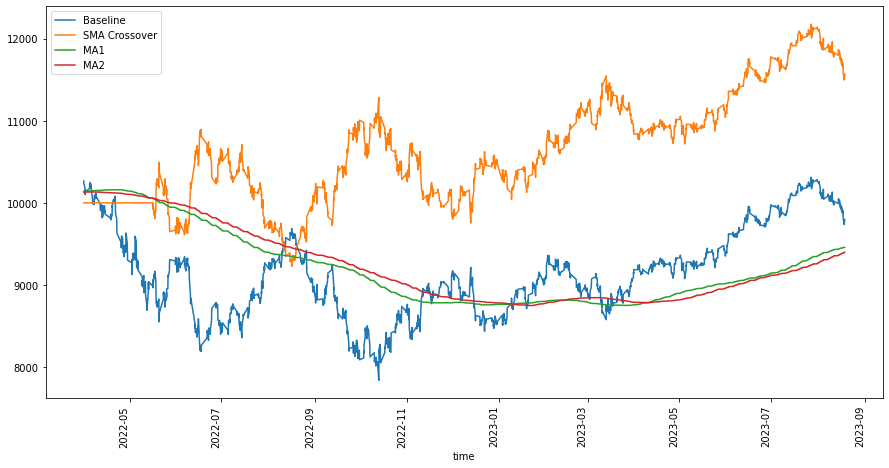

{'final_return_rate': 0.15679500797553048,
 'hit_rate': 'N/A',
 'baseline_return_rate': -0.020262352725916366,
 'quarter_return_rates': [0.0,
  0.0,
  0.02284913860656168,
  -0.04727713150564705,
  0.08610327042410382,
  0.041168087465524694,
  0.09800948588601499],
 'quarter_trades': [0, 0, 1, 0, 1, 2, 0],
 'quarter_hit_rates': ['N/A', 'N/A', 0.0, 'N/A', 'N/A', 0.0, 'N/A'],
 'baseline_return_rates': [0.02649385895101286,
  -0.0967362339348351,
  -0.007874015748031482,
  -0.04727713150564705,
  0.0388321969745562,
  0.025117798270748448,
  0.09800948588601499],
 'balance_data':                           time      Baseline  SMA Crossover           MA1  \
 1071 2022-03-31 13:30:00-04:00  10264.938590   10000.000000  10138.129901   
 1072 2022-03-31 14:30:00-04:00  10250.471601   10000.000000  10138.759320   
 1073 2022-03-31 15:30:00-04:00  10232.724981   10000.000000  10139.351220   
 1074 2022-04-01 09:30:00-04:00  10183.080102   10000.000000  10139.754800   
 1075 2022-04-01 10:30:00-

In [20]:
# test them
# Run the crossover backtester with shorting
backtest_results = sma_crossover_backtester(
            sampled_data = spy_data,
            order_sizing = 1,
            ma1_length = 934, 
            ma2_length = 1071, 
            starting_capital = 10000,
            display_results=True,
            shorting_allowed=True,
            fixed_fee = True,
            record_balance = True,
            show_moving_averages=True,
            annual_taxes=True,
            tax_percentage=0.3, # taking 30% of gains as taxes
            fee = 0
        )

backtest_results

In [18]:
no_shorting_100_runs = run_multiple_backtests(shorting_allowed=False, num_runs = 100)
no_shorting_100_runs.to_csv("sma_crossover_no_shorting_100_runs_{todays_date}.csv".format(todays_date=end_date))
no_shorting_100_runs

  0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  1%|          | 1/100 [00:00<00:58,  1.70it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  2%|▏         | 2/100 [00:01<01:04,  1.53it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is try

,ma1_length,ma2_length,cumulative_return,cumulative_baseline_return,profitable_quarters,total_trades,quarters_beating_baseline_results,strategy_quarterly_stdev,baseline_quarterly_stdev
0,131,1057,-0.029294,-0.020262,2,5,0.43,0.050446,0.063933
1,227,530,-0.149388,-0.020262,2,6,0.25,0.069474,0.059986
2,117,747,-0.052157,-0.020262,1,8,0.38,0.048215,0.058125
3,283,435,-0.090249,-0.020262,3,10,0.50,0.066630,0.059188
4,59,806,-0.005612,-0.020262,3,9,0.29,0.046215,0.058942
...,...,...,...,...,...,...,...,...,...
95,957,1012,-0.043979,-0.020262,3,6,0.43,0.066658,0.055623
96,5,869,-0.019781,-0.020262,1,23,0.57,0.043009,0.054290
97,859,1002,0.170470,-0.020262,3,4,1.00,0.040061,0.054041
98,959,1010,-0.032339,-0.020262,3,6,0.43,0.065091,0.056051


In [21]:
# 48 of 100 runs were more profitable than buy and hold
len(no_shorting_100_runs[no_shorting_100_runs.cumulative_return > no_shorting_100_runs.cumulative_baseline_return])

67

In [22]:
# are there any strategies that are consistently more profitable than buy and hold and have less variation?
# and that also outperform baseline?
no_shorting_100_runs[no_shorting_100_runs.quarters_beating_baseline_results > 0.5][no_shorting_100_runs.strategy_quarterly_stdev < no_shorting_100_runs.baseline_quarterly_stdev][no_shorting_100_runs.cumulative_return > no_shorting_100_runs.cumulative_baseline_return]

/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,ma1_length,ma2_length,cumulative_return,cumulative_baseline_return,profitable_quarters,total_trades,quarters_beating_baseline_results,strategy_quarterly_stdev,baseline_quarterly_stdev
10,754,1025,0.099687,-0.020262,2,4,0.57,0.038730,0.057346
12,592,919,0.042725,-0.020262,2,4,0.57,0.038114,0.052674
13,597,995,0.086114,-0.020262,2,2,0.71,0.037175,0.052743
14,920,1087,0.120186,-0.020262,3,4,0.57,0.036384,0.062577
15,619,1052,0.094894,-0.020262,2,2,0.57,0.037891,0.061545
19,580,746,0.105928,-0.020262,4,4,0.62,0.033592,0.057994
21,439,957,0.050940,-0.020262,2,2,0.57,0.036975,0.052827
24,450,1009,0.080410,-0.020262,3,1,0.57,0.036388,0.055309
25,498,1002,0.062694,-0.020262,2,1,0.57,0.036557,0.054041
27,206,968,0.034101,-0.020262,2,3,0.57,0.038422,0.052880


/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


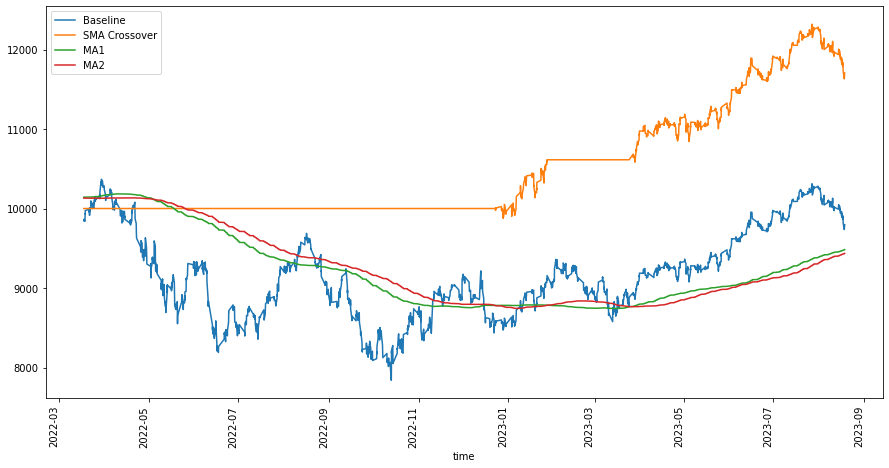

{'final_return_rate': 0.1704701599167442,
 'hit_rate': 'N/A',
 'baseline_return_rate': -0.020262352725916366,
 'quarter_return_rates': [0.0,
  0.0,
  0.0,
  0.0,
  0.06129706950235203,
  0.050599327866262644,
  0.09800948588601521],
 'quarter_trades': [0, 0, 1, 0, 2, 1, 0],
 'quarter_hit_rates': ['N/A', 'N/A', 1.0, 'N/A', 1.0, 'N/A', 'N/A'],
 'baseline_return_rates': [-0.015387739345772422,
  -0.058314886041760605,
  -0.007874015748031482,
  -0.04727713150564705,
  0.0388321969745562,
  0.025117798270748448,
  0.09800948588601499],
 'balance_data':                           time     Baseline  SMA Crossover           MA1  \
 1002 2022-03-17 14:30:00-04:00  9846.122607   10000.000000  10142.706666   
 1003 2022-03-17 15:30:00-04:00  9864.205828   10000.000000  10142.830491   
 1004 2022-03-18 09:30:00-04:00  9839.158873   10000.000000  10142.943464   
 1005 2022-03-18 10:30:00-04:00  9878.245723   10000.000000  10143.048984   
 1006 2022-03-18 11:30:00-04:00  9877.122806   10000.000000  

In [25]:
# view some of them
backtest_results = sma_crossover_backtester(
            sampled_data = spy_data,
            order_sizing = 1,
            ma1_length = 859, 
            ma2_length = 1002, 
            starting_capital = 10000,
            display_results=True,
            shorting_allowed=False,
            fixed_fee = True,
            record_balance = True,
            show_moving_averages=True,
            annual_taxes=True,
            tax_percentage=0.3, # taking 30% of gains as taxes
            fee = 0
        )

backtest_results